In [1]:
import pandas as pd
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F

#Generate random eigenvalues
eigen_arr = []
for i in range(1,101):
    eigen_arr.append(random.uniform(-6,6))
    
#Standard deviation and x-values of energy spectrum
#0.1 ev
sigma = 0.1
Denom = 2*sigma

#4.5 stds to encapsulate nearly all of the data.
#This number is arbitrary above at least 4*sigma
x = torch.unsqueeze(torch.linspace(-4.5*sigma, 4.5*sigma, 500), dim=1) 
x = Variable(x)
#Gaussian defined as pytorch tensor
y_train = torch.exp(-x.pow(2)/(2*Denom), out=None)

#Set up the neural network as class Gauss
class Gauss(nn.Module):
        
        def __init__(self, n_feature, n_hidden, n_output):
            super(Gauss, self).__init__()
            self.hidden = torch.nn.Linear(n_feature, n_hidden) 
            self.predict = torch.nn.Linear(n_hidden, n_output)   
            
        def forward(self, x):
            x = F.elu(self.hidden(x))            
            x = self.predict(x)             
            return x



#Initialize the model as instance of class, 
#Good results found for lr = 0.09 and n_hidden = 24 nodes
G = Gauss(n_feature=1, n_hidden=24, n_output=1) 
optimizer = torch.optim.SGD(G.parameters(), lr=0.09) 
loss_func = torch.nn.MSELoss() 

#Train the model, and print out predictions, losses
EPOCHS = 150000
train_loss = []
y_pred = []

for i in range(1,EPOCHS+1): 
    G.train()
    prediction = G(x)       
    loss = loss_func(prediction, y_train)      
    optimizer.zero_grad()    
    loss.backward()          
    optimizer.step()      
    train_loss.append(loss.data.numpy()) 
y_pred.append(prediction.data.numpy())  

#Test model, call this function for each eigenvalue to predict gauss
#for each eigenvalue
def predict(x, model):
    y_test = torch.exp(-x.pow(2)/(2*Denom), out=None) 
    model.eval() 
    preds = model(x) 
    losst = loss_func(preds, y_test)    
    optimizer.zero_grad() 
    losst.backward() 
    optimizer.step()   
    return preds.data.tolist() 

In [2]:
data = []
for eigenvalues in eigen_arr:
    data.append(predict(x,G))

In [3]:
pos = []
for eigenvalues in eigen_arr:
    pos.append((x+eigenvalues).tolist())

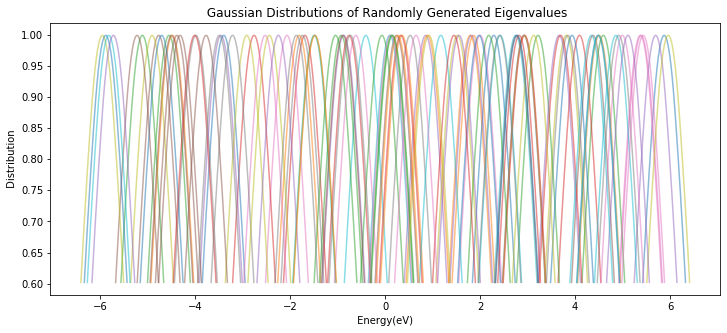

In [4]:
plt.figure(figsize = (12,5))
plt.xlabel(' Energy(eV) ')
plt.ylabel(' Distribution ')
plt.title(' Gaussian Distributions of Randomly Generated Eigenvalues')
for i in range(len(eigen_arr)):
    plt.plot(pos[i], data[i], alpha = 0.51)